# HW 2 Linear Classification with Fruits

## From the 10/03/22 Lecture Notebook
### Generative Classifiers
### Three-class generalization of logistic regression for these data using the alternative parameterization 

Oranges, Lemons and Apples dataset
https://homepages.inf.ed.ac.uk/imurray2/teaching/oranges_and_lemons/

In [2]:
# Imports
import numpy as np
import scipy as sp
from scipy.special import logsumexp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import seaborn as sns
from sklearn.datasets import load_iris

In [9]:
# Import the data
data = pd.read_csv('fruit.csv')
data.head()

,fruit,width,height
0,1,8.4,7.3
1,1,8.0,6.8
2,1,7.4,7.2
3,1,7.1,7.8
4,1,7.4,7.0


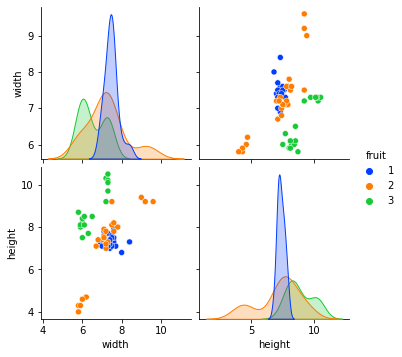

In [10]:
# Plot the data.
sns.pairplot(data, hue= 'fruit', palette='bright')  # kind='kde'

In [11]:
# Format the input data.
x0 = np.ones(data.shape[0])
x1 = data['height'].values 
x2 = data['width'].values
X = np.vstack([x1, x2]).T  # Ignore x0 for now. 

# Output data.
y = data['fruit'].values 

# Check shapes.
print(X.shape, y.shape)

(59, 2) (59,)


### Generative Classifier

In [23]:
# Let's fit a generative classifier, where the prior over class assignments is uniform (so we can ignore it). 
# We model each class as being generated by a multivariate Gaussian distribution. 
# A multivariate Gaussian is parametrized by a mean and covarance. 
# We choose to have a separate covariance for each class. Covariances could be shared to have less parameters to learn (see Bishop). 

# Let's estimate the means.
mean_apple = np.mean(X[y==1], axis=0)
mean_orange = np.mean(X[y==2], axis=0)
mean_lemon = np.mean(X[y==3], axis=0)

# Let's estimate the covariances.
cov_apple = np.cov(X[y==1], rowvar=False)  # rowvar=False defines the columns as the variables
cov_orange = np.cov(X[y==2], rowvar=False)
cov_lemon = np.cov(X[y==3], rowvar=False)

# Let's define the PDFs of each class Gaussian.
pdf_apple = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_apple, cov=cov_apple)
pdf_orange = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_orange, cov=cov_orange)
pdf_lemon = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_lemon, cov=cov_lemon)

In [25]:
# Can plot the learned decision boundaries.
grid_x = np.arange(0,11,0.05)
grid_y = np.arange(0,10,0.05)
grid = np.zeros((len(grid_x), len(grid_y)))
for ix, ex in enumerate(grid_x):
  for iy, ey in enumerate(grid_y):
    grid[ix, iy] = np.argmax([pdf_apple([ex,ey]), pdf_orange([ex,ey]), pdf_lemon([ex,ey])])  # Predictions.

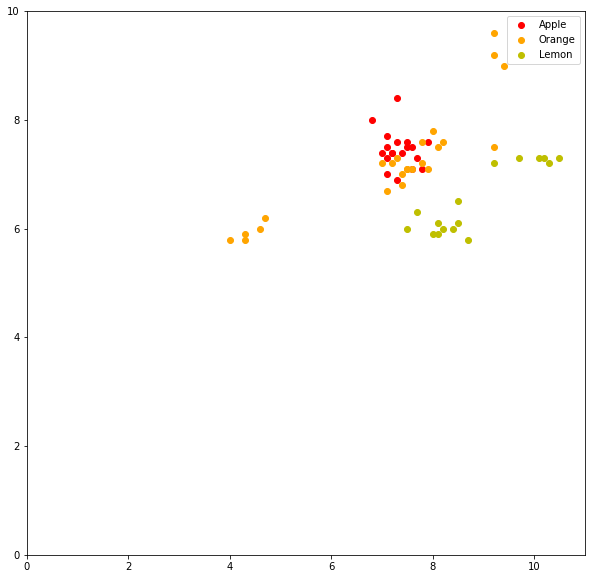

In [33]:
# Plot data.
plt.figure(figsize=(10,10))
plt.plot(X[y==1,0], X[y==1,1], 'ro', label='Apple')
plt.plot(X[y==2,0], X[y==2,1], 'o', color="orange", label='Orange')
plt.plot(X[y==3,0], X[y==3,1], 'yo', label='Lemon')
plt.xlim([0,11])
plt.ylim([0,10])
plt.legend()

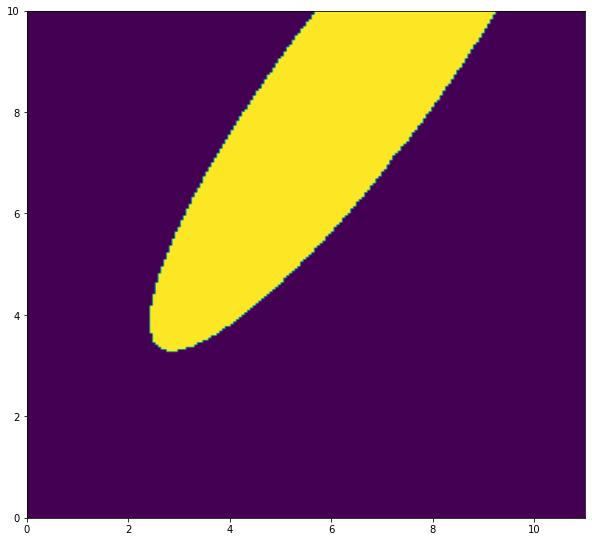

In [48]:
# Can plot the learned decision boundaries.
plt.figure(figsize=(10,10))
plt.imshow(np.flip(grid, 0)==2, extent=(0,11,0,10))  # flip is needed as imshow plots in image coordinates
# plt.colorbar()

### Three-class generalization of logistic regression for these data using the alternative parameterization 

In [49]:
# Next, let's look at logistic regression.
# Let's write a class that broadly follows the sklearn interface. 
class LogisticRegression:
    def __init__(self, eta, lambda_parameter):
        self.eta = eta
        self.lambda_parameter = lambda_parameter

    # Numerically stable calculation of log softmax
    # Uses the property that log(softmax(z)) = z - log(sum(exp(z)))
    def __log_softmax(self, X, W):
        res = X.dot(W.T) - X.dot(W.T)[-1]
        lse = logsumexp(res, axis=1)[:, np.newaxis]
        return res - lse

    def __makeOneHot(self, i):
        onehot = np.zeros(self.nClasses)
        onehot[i] = 1
        return onehot

    def __makeAllOneHot(self, Y):
        return np.array([self.__makeOneHot(y) for y in Y])

    # Note that this is calculating the gradient over the whole training set
    # Assumes that Y is given as a one-hot vector.
    # Also adds regularization, 'lambda' is a reserved keyword in python.

    # Step 1: Write down the likelihood equation (3.15).
    # Step 2: Take the negative log (3.16).
    # Step 3: Compute the gradient (3.17).
    def __gradient(self):  # Equation (3.17).
        log_softmax_result = self.__log_softmax(self.X, self.W)
        softmax_result = np.exp(log_softmax_result)
        diff = softmax_result - self.Y
        W_grad  =  diff.T.dot(self.X)
        return W_grad + 2 * self.lambda_parameter * self.W

    def __updateParameters(self):
        W_grad = self.__gradient()
        self.W = self.W - W_grad * self.eta
        return W_grad

    def __loss(self):
        total_loss = 0.
        log_softmax_res = self.__log_softmax(self.X, self.W)
        total_loss = -np.sum(self.Y * log_softmax_res)
        # Add regularization.
        return total_loss + self.lambda_parameter * (np.power(self.W, 2).sum())


    def fit(self, X, Y):
        assert(X.shape[0] == Y.shape[0])

        # Add a column of 1s
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)

        nClasses = max(Y) + 1
        nFeatures = X.shape[1]
        N = X.shape[0]
        self.nClasses = nClasses
        self.nFeatures = nFeatures
        self.X = X
        self.C = Y
        self.Y = self.__makeAllOneHot(Y)
        self.N = N
        self.W = np.zeros((nClasses, nFeatures))

        print(self.__loss())
        epoch = 0
        while True:
            epoch += 1
            # Update the gradient
            gradient = self.__updateParameters()

            # Every 100000 times, also calculate the gradient norm and loss, and
            # display it.
            if epoch % 100000 == 0:
                norm = np.linalg.norm(gradient)
                loss = self.__loss()
                print("On epoch: {}".format(epoch))
                print("   Gradient norm is {}".format(norm))
                print("   Loss is {}".format(loss))
                #print(self.W)
                if norm < .000001:
                    break

    def predict(self, X_to_predict): # Often in sklearn, you will see predict and predict_proba.
        X_to_predict = np.append(X_to_predict, np.ones((X_to_predict.shape[0],
                                                        1)), axis=1)
        softmax_res = X_to_predict.dot(self.W.T)
        predictions = np.argmax(softmax_res, axis=1)
        print(np.bincount(predictions))
        return predictions

    def visualize(self, width=2):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min,
            y_max, .05))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))
        
        cMap = c.ListedColormap(['r','orange','y'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap, alpha=0.1)
        plt.scatter(X[:, 0], X[:, 1], c=self.C, cmap=cMap)
        plt.show()

81.79136730607354
On epoch: 100000
   Gradient norm is 15.218218973450297
   Loss is 32998.38775207345
On epoch: 200000
   Gradient norm is 2.03087566481845
   Loss is 41024.10540782987
On epoch: 300000
   Gradient norm is 0.27186357031926267
   Loss is 42161.33942331592
On epoch: 400000
   Gradient norm is 0.03644353875799548
   Loss is 42314.7924995888
On epoch: 500000
   Gradient norm is 0.0048908011446432
   Loss is 42335.389298640264
On epoch: 600000
   Gradient norm is 0.0006570220047178084
   Loss is 42338.15445837146
On epoch: 700000
   Gradient norm is 8.834455606568274e-05
   Loss is 42338.526012158705
On epoch: 800000
   Gradient norm is 1.1888924678697578e-05
   Loss is 42338.57598211604
On epoch: 900000
   Gradient norm is 1.6011572448002697e-06
   Loss is 42338.582708035836
On epoch: 1000000
   Gradient norm is 2.1578600492214813e-07
   Loss is 42338.58361401224
[    0     0  5625 27135]


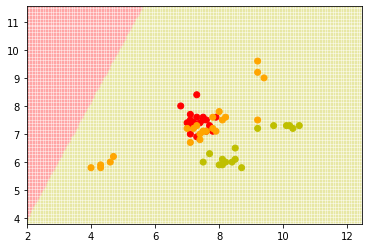

In [50]:
eta = 0.0001
lambda_parameter = 0.1
lr = LogisticRegression(eta=eta, lambda_parameter=lambda_parameter)
lr.fit(X,y)
lr.visualize()